# Анализ удержания пользователей

## **Цель блокнота**
Исследовать, зависит ли дальнейшее удержание пользователей от момента совершения первого заказа:
- месяца
- дня недели
- времени суток.

## 1. Подготовка данных

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [17]:
customers = pd.read_csv(
    "olist_customers_dataset.csv")

orders = pd.read_csv(
    "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ],
    dtype={
        "order_id": "string",
        "customer_id": "string",
        "order_status": "string"
    }
)

payments = pd.read_csv(
    "olist_order_payments_dataset.csv")

items = pd.read_csv(
    "olist_order_items_dataset.csv",
    parse_dates=["shipping_limit_date"]
)

customers_unique = customers[["customer_id", "customer_unique_id"]]
orders_users = orders.merge(
    customers_unique,
    on="customer_id",
    how="left")

delivered_orders = orders_users[
    orders_users["order_status"] == "delivered"].copy()

first_orders = (
    delivered_orders
    .sort_values("order_purchase_timestamp")
    .groupby("customer_unique_id")
    .first()
    .reset_index())


In [18]:
# Месяц первого заказа
first_orders["first_order_month"] = (
    first_orders["order_purchase_timestamp"].dt.month)

In [19]:
# День недели первого заказа
first_orders["first_order_weekday"] = (
    first_orders["order_purchase_timestamp"].dt.dayofweek)

In [31]:
# Время суток первого заказа
first_orders["first_order_hour"] = (
    first_orders["order_purchase_timestamp"].dt.hour)


## **2. Определение retention**


Пользователь считается удержанным, если он совершил как минимум одну повторную покупку после первого заказа.

In [21]:
orders_cnt = (
    delivered_orders
    .groupby("customer_unique_id")["order_id"]
    .nunique()
    .reset_index(name="orders_cnt")
)

first_orders = first_orders.merge(
    orders_cnt,
    on="customer_unique_id",
    how="left"
)

first_orders["is_retained"] = first_orders["orders_cnt"] >= 2


## **3. Retention по месяцу первого заказа**


In [22]:
retention_by_month = (
    first_orders
    .groupby("first_order_month")["is_retained"]
    .mean()
)

retention_by_month

,is_retained
first_order_month,
1,0.034396
2,0.038151
3,0.030506
4,0.026137
5,0.029226
6,0.025911
7,0.027111
8,0.022057
9,0.044944


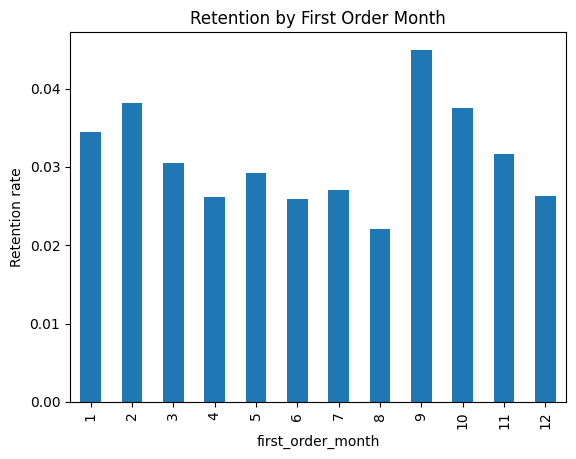

In [23]:
retention_by_month.plot(
    kind="bar",
    title="Retention by First Order Month"
)
plt.ylabel("Retention rate")
plt.show()

## **4. Retention по дню недели первого заказа**

In [27]:
weekday_labels = {
    0: "Mon",
    1: "Tue",
    2: "Wed",
    3: "Thu",
    4: "Fri",
    5: "Sat",
    6: "Sun"}

retention_by_weekday = (
    first_orders
    .groupby("first_order_weekday")["is_retained"]
    .mean()
).rename(index=weekday_labels)

retention_by_weekday

,is_retained
first_order_weekday,
Mon,0.029334
Tue,0.028961
Wed,0.031316
Thu,0.031008
Fri,0.029567
Sat,0.029420
Sun,0.030397


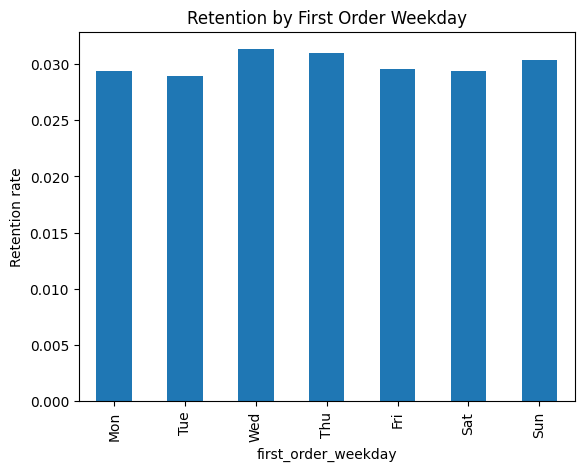

In [28]:
retention_by_weekday.plot(
    kind="bar",
    title="Retention by First Order Weekday"
)
plt.ylabel("Retention rate")
plt.show()

## **5. Retention по времени суток первого заказа**

In [32]:
retention_by_hour = (
    first_orders
    .groupby("first_order_hour")["is_retained"]
    .mean()
    .sort_index()
)

retention_by_hour


,is_retained
first_order_hour,
0,0.035682
1,0.033883
2,0.062500
3,0.052846
4,0.067708
5,0.035088
6,0.050328
7,0.035057
8,0.030521


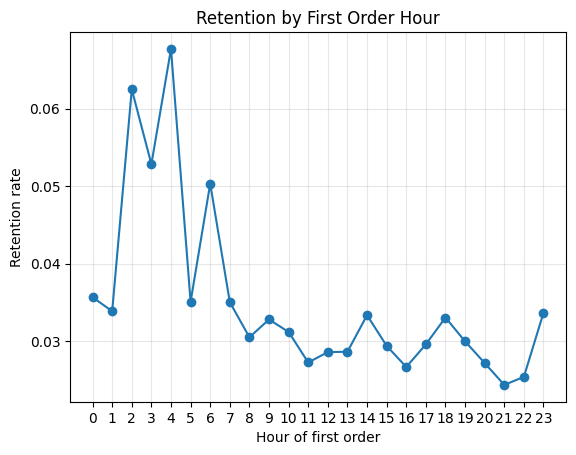

In [33]:
retention_by_hour.plot(
    kind="line",
    marker="o",
    title="Retention by First Order Hour"
)

plt.xlabel("Hour of first order")
plt.ylabel("Retention rate")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()




In [34]:
orders_by_hour = (
    first_orders
    .groupby("first_order_hour")["customer_unique_id"]
    .nunique()
)

orders_by_hour


,customer_unique_id
first_order_hour,
0,2242
1,1092
2,480
3,246
4,192
5,171
6,457
7,1141
8,2785


Наблюдается повышенный retention в ночные часы (02:00–04:00),
однако данный эффект сопровождается значительно меньшим
размером выборки по сравнению с дневными периодами.

Это повышает неопределённость оценки и требует осторожной
интерпретации результата.

Повышенный retention в ночные часы может быть связан
с более осознанным или целенаправленным поведением пользователей,
однако данный эффект может также объясняться
выборочным характером аудитории и малым объёмом наблюдений.

In [48]:
from scipy.stats import kruskal

groups = [
    first_orders.query("first_order_hour == @h")["is_retained"].astype(int)
    for h in range(24)
]

stat, p_value = kruskal(*groups)
print('p-value:', p_value)


p-value: 4.787212801816709e-06


Для проверки влияния часа первого заказа на удержание пользователей
был применён непараметрический тест Kruskal–Wallis.

p-value < 0.05 указывает на статистически значимые различия
в retention между пользователями, совершившими первый заказ в разное время суток.
При этом следует учитывать размер групп: ночные часы содержат
значительно меньше пользователей, что увеличивает неопределённость оценки.


## **6. Интерпретация результатов и ограничения анализа**

### Выводы

1. Retention различается в зависимости от месяца первого заказа, что может быть связано с сезонностью спроса и качеством первого пользовательского опыта.

2. Наблюдаются различия в удержании пользователей в зависимости от дня недели первой покупки, что может отражать различия в контексте и мотивации покупки.

3. Retention также зависит от времени суток первого заказа. Это указывает на то, что контекст первой покупки
(спонтанная vs осознанная) может влиять
на вероятность повторного использования продукта.


### Ограничения

- Анализ носит наблюдательный характер и не устанавливает причинно-следственных связей.
- На retention могут влиять дополнительные факторы (категория товара, цена, доставка), не учтённые в данном блоке.
- Для подтверждения гипотез требуется проведение контролируемых экспериментов или A/B-тестов.
